## Including Stochasticity into MIP Recommender Systems with Bender's Cuts

In this notebook, I will briefly go over a small stochastic optimization model to discuss how stochasticity can be incorporated into recommender system problems. For the interested, in our paper "Making smart recommendations for perishable and stockout products" more details on the subject are provided: https://www.researchgate.net/publication/363516960_Making_smart_recommendations_for_perishable_and_stockout_products


In this notebook, we solve a model that finds the best stores to advertise an item in an e-retail store. In this setting, customers shop online, and our job is to maximize the revenue and minimize the distance our couriers travel between stores and customers. The couriers serve customers one at a time, therefore we are not considering path optimization. Assume that our marketing team is thinking one of the three possible option for a big advertisement in one of our stores, and we want to find which store and which item would make the most revenue to our company. Also, we want to optimize and try to meet all the demand considering stochastic nature of the inventories and demands.

The advertised item has a limited inventory therefore stockouts are possible. Different stores have different inventories and we may choose to serve customers from farther stores if closer stores are out-of-inventory. Note that we want to minimize the distance the couriers travel as well. This advertisement may or may not increase the demand of customers. Intuitively, advertisement decisions solely consider the distance and the inventory. For example, if our item has a significant inventory in a given store, it is intuitive to advertise that item. We assume we know the distribution of the demand and inventory levels. We generate scenarios from those known distributions. These scenarios will work as the personalization of the customer segments because different segments will have different behavior.

| Parameter                                | Value                |
|------------------------------------------|----------------------|
| Number of stores (j)                     | 10                   |
| Number of items  (i)                     | 3                    |
| Number of customers (u)                  | 10000                |
| Distance of customers to stores (r_{uj}) | Exp Distribution     |
| Demand of customers                      | Poisson Distribution |
| Inventory of the item                    | Poisson Distribution |
| Revenue if demand is met (p)             | Normal Distribution  |

Next, for every scenario, we create new demands, inventories, and revenue increase in case of advertisement of each item-user pair.

| Probability  | Increase in Demand |
|--------------|--------------------|
| 0.7          | 0                  |
| 0.25         | 1                  |
| 0.05         | 3                  |

The effect of advertisement on the customer is random for each user and item type combination. We are a bit pessimistic, and assume most of the customers do not care about the advertisements. Furthermore, we create a random poisson distribution for the demand of the item for every customer. Then additional stochastic demand is added with poisson distribution for every scenario.

In this problem, $U$ is the set of users, $I$ is the set of items, and $S$ is the set of stores. Our decision variable $x_{iuj}$, is the percentage of the demand satisfied from store $j \in S$ for user $u \in U$ and item $i \in I$. Decision variables $y_{ij}$ is a binary variable which determines if the advertisement is run in this store for item $i$ or not.

Our proposed Main Problem has the following form, where each scenario $w \in \Omega$ is assumed to have equal probability to occur:
$\max\limits_{x,y} \frac{1}{|\Omega|} \sum\limits_{w \in \Omega} \left[ \sum\limits_{u \in U} \sum \limits_{j \in S} ( p - r_{uj})*x^{w}_{uj}  \right]$          
<br>
$\sum \limits_{i \in I} \sum \limits_{j \in S}y_{ij} = 1 $
<br>
$\sum \limits_{j \in S} x^{w}_{iuj} \leq d^{w}_{iu} + \sum \limits_{j \in S} y_{ij}\gamma_{u} \quad (\forall i \in I, u \in U, w \in \Omega) $
<br>
$\sum \limits_{u \in U}x^{w}_{iuj} \leq b^{w}_{ij} \quad (\forall i \in I, j \in S, w \in \Omega)$
<br>
$x^{w}_{iuj} \geq 0 \quad (\forall i \in I, j \in S, u \in U, w \in \Omega)$
<br>
$y_{ij} \in \{0,1\} \quad (\forall i \in I, j \in S) $

Our objective is to maximize revenue and minimize distance travelled considering all the scenarios. First constraint qualifies that each store will have exactly one item segment advertisement. Second and third constraints give upper bounds to the item segments. A user cannot receive more items than their demand. Therefore, either the solution meets all the demand for a user, or, demand is not fully met and we gain the revenue from the demand met. Similarly, a store cannot send items more than the inventory.

If we assume we know the decision variable values of $y$, we can create subproblems for each scneario $w$. Below is the dual problem of those subproblems:

$\min\limits_{\alpha, \beta} \sum \limits_{i \in 
I} \sum \limits_{u \in U}\alpha_{iu}(d_{iu} + \sum \limits_{j \in S} \bar{y}_{ij} \gamma_{u}) + \sum \limits_{i \in 
I} \sum \limits_{j \in S} \beta_{ij}b_{ij} $ 
<br>
$\alpha_{iu} + \beta_{ij} \geq (p_i - r_{uj})   \quad (\forall i \in I, u \in U, j \in S) $

<br>
$\alpha_{iu} \geq  0 \quad (\forall i \in I, u \in U) $ 
<br>
$\beta_{ij} \geq 0 \quad (\forall i \in I, j \in S) $

Note that, because the feasible region of the decision variable $y$ is limited in the dual subproblems, the solution will be bounded. Then we will only require optimality cuts. Next are the codes for solving both multi and single cut version of two stage stochastic problems:


In [1]:
import numpy as np
from gurobipy import *
import random
import time
random.seed(1)
np.random.seed(1)

def scenario(n_sce):
    
    ### Firstly we are adding the constants of the project
    ### We assume these distributions are already available to us.
    params = {}
    params['store_num'] = 15; params['item_num'] = 3; params['cust_num'] = 200;  params['revenue'] = np.random.normal(100,10,(params['item_num']))
    params['distance'] = np.random.exponential(50,(params['cust_num'], params['store_num'])) 
    inventory_dist = np.random.poisson(70,(params['store_num'], params['item_num']))
    demand_dist = np.random.poisson(2,(params['cust_num'],params['item_num']))
    params['sce_num'] = n_sce; params['demand_dist'] = demand_dist; params['inventory_dist'] = inventory_dist

    
    ### Secondly, we generate the uncertainty
    params['inventory'] = []; params['demand']=[];  params['effect'] = []
    for w in range(params['sce_num']):
        params['inventory'].append(np.random.normal(inventory_dist,10,(inventory_dist.shape)))
        u1 = np.random.uniform(0,1, (params['cust_num'],params['item_num']))
        params['demand'].append(np.abs(demand_dist + (1*(u1 >0.5) -1*(u1 <0.5))*np.random.poisson(5,(params['cust_num'],params['item_num']))))
        u = np.random.uniform(0,1, (params['cust_num']))
        params['effect'].append( 1*(0.7 < u ) + 2*(0.95 < u))
    
    return params

def Full_problem(rs): #The problem we solve including all the scenarios at the same time
    print('Solve the Whole Problem')
    m = Model('Full')

    
    ### Adding the decision variables 
    x = m.addVars(rs['sce_num'], rs['item_num'], rs['cust_num'], rs['store_num'], lb=0.0, vtype=GRB.CONTINUOUS, name = "x")
    y = m.addVars(rs['item_num'], rs['store_num'], vtype=GRB.BINARY, name = "y") 
    m.setObjective((1/rs['sce_num'])*quicksum((rs['revenue'][i]-rs['distance'][u,j])*x[w,i,u,j] for i in range(rs['item_num']) for w in range(rs['sce_num']) for u in range(rs['cust_num'])  for j in range(rs['store_num'])), GRB.MAXIMIZE)
    
    #### Adding the constraints
    m.addConstr(quicksum(y[i,j] for j in range(rs['store_num']) for i in range(rs['item_num'])) == 1)
    m.addConstrs(quicksum(x[w,i,u,j] for j in range(rs['store_num'])) <= rs['demand'][w][u,i] + quicksum(y[i,j]*rs['effect'][w][u] for j in range(rs['store_num'])) for w in range(rs['sce_num'])  for u in range(rs['cust_num']) for i in range(rs['item_num']))
    m.addConstrs(quicksum(x[w,i,u,j] for u in range(rs['cust_num'])) <= rs['inventory'][w][j,i] for j in range(rs['store_num']) for w in range(rs['sce_num']) for i in range(rs['item_num']))

    m.optimize()
    return m     
    
def EV_model(rs):  ## Expected Value model
    m = Model('EV')
    print('Solve the EV problem')
    rs['sce_num'] = 1; rs['demand'] = rs['demand_dist'] ; rs['effect'] = 0.4 #expected values of the distributions
    rs['inventory'] = rs['inventory_dist']
    
    ### Adding the decision variables 
    y = m.addVars(rs['item_num'], rs['store_num'], vtype=GRB.BINARY, name = "y") 
    x = m.addVars(rs['sce_num'], rs['item_num'], rs['cust_num'], rs['store_num'], lb=0.0, vtype=GRB.CONTINUOUS, name = "x")
    m.setObjective(quicksum((rs['revenue'][i]-rs['distance'][u,j])*x[w,i,u,j] for i in range(rs['item_num']) for w in range(rs['sce_num']) for u in range(rs['cust_num'])  for j in range(rs['store_num'])), GRB.MAXIMIZE)
    
    #### Adding the constraints
    m.addConstr(quicksum(y[i,j] for j in range(rs['store_num']) for i in range(rs['item_num'])) <= 3)
    m.addConstrs(quicksum(x[0,i,u,j] for j in range(rs['store_num'])) <= rs['demand'][u,i] + quicksum(y[i,j]*rs['effect'] for j in range(rs['store_num'])) for u in range(rs['cust_num']) for i in range(rs['item_num']))
    m.addConstrs(quicksum(x[0,i,u,j] for u in range(rs['cust_num'])) <= rs['inventory'][j,i] for j in range(rs['store_num']) for i in range(rs['item_num']))

    m.optimize()
    return m




def Benders_Main_multi_cut(rs):  ##Benders main function - multi cut formulation
    start = time.time()
    times = []; solution_array = []
    times.append(0)
    m = Model('Master')
    ub = 1e6; lb = -1e6
    
    m.setParam(GRB.Param.OutputFlag, 0)
    y = m.addVars(rs['item_num'], rs['store_num'], vtype=GRB.BINARY, name = "y") 
    z = m.addVars(rs['sce_num'], lb=-1e6, ub=1e6)
    
    m.setObjective((1/rs['sce_num'])*quicksum(z[w] for w in range(rs['sce_num'])), sense= GRB.MAXIMIZE) 

    m.addConstr(quicksum(y[i,j] for j in range(rs['store_num']) for i in range(rs['item_num'])) <= 3)
    m.optimize()
    ub = m.objVal
    
    while abs((ub-lb)/lb) >= 0.0001:
        print('Multi-cut Loop')
        sub_problem_obj = []
        for w in range(rs['sce_num']):     
            dual1, dual2, obj = Benders_Dual_Sub(w, y, rs) # a bit slow here

            m.addConstr(z[w] <= quicksum((rs['demand'][w][u,i]+quicksum(y[i,j]*rs['effect'][w][u] for j in range(rs['store_num'])))*dual1[i,u] for i in range(rs['item_num']) for u in range(rs['cust_num'])) + 
                    quicksum(dual2[i,j]*rs['inventory'][w][j,i] for i in range(rs['item_num']) for j in range(rs['store_num'])))
            sub_problem_obj.append(obj)
        m.update()
        m.optimize()
        m.update()

        ub = m.objVal
        lb = max(sum(sub_problem_obj)/rs['sce_num'],lb)
        
        times.append(time.time()- start)
        start = time.time()
        solution_array.append(lb)
        print('ub', ub)
        print('lb', lb)
    return lb, solution_array, times, m


def Benders_Main_single_cut(rs):   ## Single cut formulation
    
    m = Model('Master')
    ub = 1e6; lb = -1e6

    m.setParam(GRB.Param.OutputFlag, 0)
    y = m.addVars(rs['item_num'], rs['store_num'], vtype=GRB.BINARY, name = "y") 
    z = m.addVar(lb=-1e6, ub=1e6)
    
    m.setObjective(z, sense= GRB.MAXIMIZE) 

    m.addConstr(quicksum(y[i,j] for j in range(rs['store_num']) for i in range(rs['item_num'])) <= 5)
    m.optimize()
    ub = m.objVal

    while abs((ub-lb)/lb) >= 0.001:
        print('Single-cut Loop')
        dual_cuts = []
        sub_problem_obj = []
        for w in range(rs['sce_num']):       
            dual1, dual2, obj = Benders_Dual_Sub(w, y, rs)
            dual_cuts.append([dual1,dual2])
            sub_problem_obj.append(quicksum((rs['demand'][w][u,i]+quicksum(y[(i,j)].x*rs['effect'][w][u] for j in range(rs['store_num'])))*dual1[i,u] for i in range(rs['item_num']) for u in range(rs['cust_num'])) + 
                    quicksum(dual2[i,j]*rs['inventory'][w][j,i] for i in range(rs['item_num']) for j in range(rs['store_num'])))            
#        print(len(dual_cuts))
        m.addConstr(z <= quicksum((rs['demand'][w][u,i]+quicksum(y[i,j]*rs['effect'][w][u] for j in range(rs['store_num'])))*dual_cuts[w][0][i,u]/rs['sce_num']
        for i in range(rs['item_num']) for u in range(rs['cust_num']) for w in range(rs['sce_num'])) + 
                quicksum(dual_cuts[w][1][i,j]*rs['inventory'][w][j,i]/rs['sce_num'] for i in range(rs['item_num']) for j in range(rs['store_num']) for w in range(rs['sce_num'])))

        m.update()
        m.optimize()
        m.update()
        ub = m.objVal
        lb = max(sum(sub_problem_obj)/rs['sce_num'],lb)
        print('ub', ub)
        print('lb', lb)
    return lb

        
def Benders_Dual_Sub(w, y_sol, rs):   ## Dual sub problems
    ms = Model('Sub')
   
    ms.setParam(GRB.Param.OutputFlag, 0)
    new_demand = np.zeros((rs['cust_num'],rs['item_num']))
    for u in range(rs['cust_num']):
        for i in range(rs['item_num']):
            new_demand[u,i] =  rs['demand'][w][u,i] + sum([y_sol[(i,j)].x*rs['effect'][w][u] for j in range(rs['store_num'])])
                        
    alpha = ms.addVars(rs['item_num'], rs['cust_num'], lb=0.0, vtype=GRB.CONTINUOUS, name = "a")
    beta  = ms.addVars(rs['item_num'], rs['store_num'], lb=0.0, vtype=GRB.CONTINUOUS, name = "b")

    ms.setObjective(quicksum(new_demand[u,i]*alpha[i,u] for i in range(rs['item_num']) for u in range(rs['cust_num'])) + 
                    quicksum(beta[i,j]*rs['inventory'][w][j,i] for i in range(rs['item_num']) for j in range(rs['store_num'])), GRB.MINIMIZE)
    ms.addConstrs(alpha[i,u] + beta[i,j] >= rs['revenue'][i]-rs['distance'][u,j] for i in range(rs['item_num']) for u in range(rs['cust_num'])  for j in range(rs['store_num']))
    ms.optimize()
    
    alpha_sol = np.array([alpha[key].x for key in alpha.keys()])
    beta_sol  = np.array([beta[key].x for key in beta.keys()])

    return alpha_sol.reshape((rs['item_num'], rs['cust_num'])), beta_sol.reshape((rs['item_num'], rs['store_num'])), ms.objVal




     
     

In [32]:
solution_Benders = {}
number_of_scenarios = [1,2,5,15,25,50]
for yz in number_of_scenarios:
    params = scenario(yz)
    objval, sols, times,m = Benders_Main_multi_cut(params)
    solution_Benders[yz] = m

Multi-cut Loop
ub 311869.4205944267
lb 285144.3229684419
Multi-cut Loop
ub 293970.17337734863
lb 291964.81256435544
Multi-cut Loop
ub 292929.0150627076
lb 292256.0729334287
Multi-cut Loop
ub 292439.1085766865
lb 292439.0680107694
Multi-cut Loop
ub 311693.0623597988
lb 292064.9522321689
Multi-cut Loop
ub 310750.5457487507
lb 294847.4939587921
Multi-cut Loop
ub 303813.85728450003
lb 295471.4605370579
Multi-cut Loop
ub 301758.5326799394
lb 300112.8653439596
Multi-cut Loop
ub 300718.85352722474
lb 300112.8653439596
Multi-cut Loop
ub 300388.5069271645
lb 300112.8653439596
Multi-cut Loop
ub 300112.86534395965
lb 300112.8653439596
Multi-cut Loop
ub 325456.4761895081
lb 303390.4396617896
Multi-cut Loop
ub 322135.97070596623
lb 310267.42837207334
Multi-cut Loop
ub 315974.8523002907
lb 310267.42837207334
Multi-cut Loop
ub 313092.76714132924
lb 311489.6703116892
Multi-cut Loop
ub 312638.81516737805
lb 311489.6703116892
Multi-cut Loop
ub 311620.9574213569
lb 311620.95742135687
Multi-cut Loop
ub 32

In [33]:
solution_EV = EV_model(params)

Solve the EV problem
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 646 rows, 9045 columns and 27045 nonzeros
Model fingerprint: 0xc12b1ed5
Variable types: 9000 continuous, 45 integer (45 binary)
Coefficient statistics:
  Matrix range     [4e-01, 1e+00]
  Objective range  [1e-02, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+01]
Found heuristic solution: objective 76123.969777
Presolve removed 0 rows and 1240 columns
Presolve time: 0.02s
Presolved: 646 rows, 7805 columns, 16207 nonzeros
Variable types: 7802 continuous, 3 integer (0 binary)

Root relaxation: objective 1.346923e+05, 1148 iterations, 0.04 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node

Of course, this is a toy example but we can still investigate some of the results between using stochasticity with Benders versus solving a deterministic model using only expectations. If we want to increase the size of the data, this problem proves really complex. To alleviate this problem, we can use distributed optimization, so that subproblems will be solved in different machines simultaneously to increase the speed time. Similarly, model can be built in a smarter way, as in https://www.researchgate.net/publication/363516960_Making_smart_recommendations_for_perishable_and_stockout_products.

Now, we will compare the results using the previously recorded solutions of EV and Benders models.

In [34]:
def Full_problem_fixed_solution(rs, solution_fixed):  #### The problem we solve with fixed first stage decision variables
    all_sols = []; all_obj = []
    rs['sce_num'] = 1
    for w in range(250):        
        m = Model('WS')
        m.setParam(GRB.Param.OutputFlag, 0)
        
        ### Adding the decision variables 
        x = m.addVars(rs['sce_num'], rs['item_num'], rs['cust_num'], rs['store_num'], lb=0.0, vtype=GRB.CONTINUOUS, name = "x")
        y = m.addVars(rs['item_num'], rs['store_num'], vtype=GRB.CONTINUOUS, name = "y") 
        m.setObjective(quicksum((rs['revenue'][i]-rs['distance'][u,j])*x[w,i,u,j] for i in range(rs['item_num']) for w in range(rs['sce_num']) for u in range(rs['cust_num'])  for j in range(rs['store_num'])), GRB.MAXIMIZE)
        
        #### Adding the constraints
        m.addConstrs(y[i,j] == solution_fixed.reshape((rs['item_num'],rs['store_num']))[i,j] for i in range(rs['item_num']) for j in range(rs['store_num']))
        m.addConstrs(quicksum(x[0,i,u,j] for j in range(rs['store_num'])) <= rs['demand'][w][u,i] + quicksum(y[i,j]*rs['effect'][w][u] for j in range(rs['store_num'])) for u in range(rs['cust_num']) for i in range(rs['item_num']))
        m.addConstrs(quicksum(x[0,i,u,j] for u in range(rs['cust_num'])) <= rs['inventory'][w][j,i] for j in range(rs['store_num']) for i in range(rs['item_num']))

        m.optimize()
        all_sols.append(m.x)
        all_obj.append(m.objVal)    
    return all_sols, all_obj

number_of_scenarios = 250 #Here we want to check the quality of our solutions with 500 newly generated scenarios
params = scenario(number_of_scenarios)


all_sols, all_obj = Full_problem_fixed_solution(params,np.array(solution_EV.x[0:params['store_num']*params['item_num']]))

plt_solution = {}
plt_solution['EV'] = np.mean(all_obj)

for yz_check in [1,2,5,15,25,50]:
    all_sols, all_obj = Full_problem_fixed_solution(params,np.array(solution_Benders[yz_check].x[0:params['store_num']*params['item_num']]))
    plt_solution['Sce'+str(yz_check)] = np.mean(all_obj)




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


{'EV': 325154.2045175223, 'Sce1': 326195.5537224404, 'Sce5': 323101.2006074045, 'Sce15': 327352.4498376621, 'Sce25': 327352.4498376621, 'Sce50': 327352.4498376621}


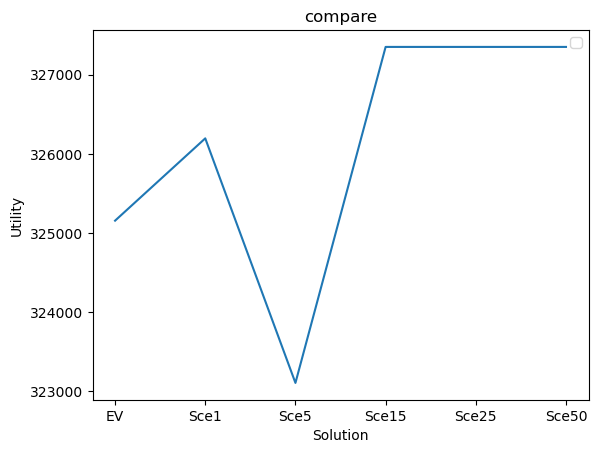

In [31]:
import matplotlib.pyplot as plt

print(plt_solution)

#lists = sorted(plt_solution.items()) 
#x, y = zip(*lists) 
#
#plt.show()
x = plt_solution.keys(); y = plt_solution.values()
plt.plot(x, y)
plt.xlabel('Solution'); plt.ylabel('Utility') 
plt.xticks(list(range(len(x))), x)
plt.title('compare')
plt.legend() 
plt.show()

We see that adding scenarios and solving our problems with stochasticity beats the value obtained with the EV method, which only uses the expected values. We observe a dip at first, however, after 15 scenarios system seems to stabilize and obtains the same solution. 

Therefore, in this notebook, we applied Bender's cuts to a problem with stochasticity and showed that utility can be improved by accounting randomness in our problems.